# DeepWalk实战-维基百科词条图嵌入可视化

## 安装工具包

In [2]:
# !pip install networkx gensim pandas numpy tqdm scikit-learn matplotlib

## 导入工具包

In [3]:
import networkx as nx # 图数据挖掘

# 数据分析
import pandas as pd
import numpy as np

import random # 随机数
from tqdm import tqdm # 进度条

# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [4]:
df = pd.read_csv("./data/bilibili_tag.csv", sep = "\t")

In [5]:
df.head()

,A,B
0,科技猎手,科技猎手2023
1,科技猎手,航空
2,科技猎手,DIY
3,科技猎手,搞笑
4,科技猎手,科技


In [6]:
df.shape

(5687, 2)

## 构建无向图

In [7]:
G = nx.from_pandas_edgelist(df, df.columns[0], df.columns[1], create_using=nx.Graph())

In [8]:
# 节点个数
len(G)

576

## 可视化

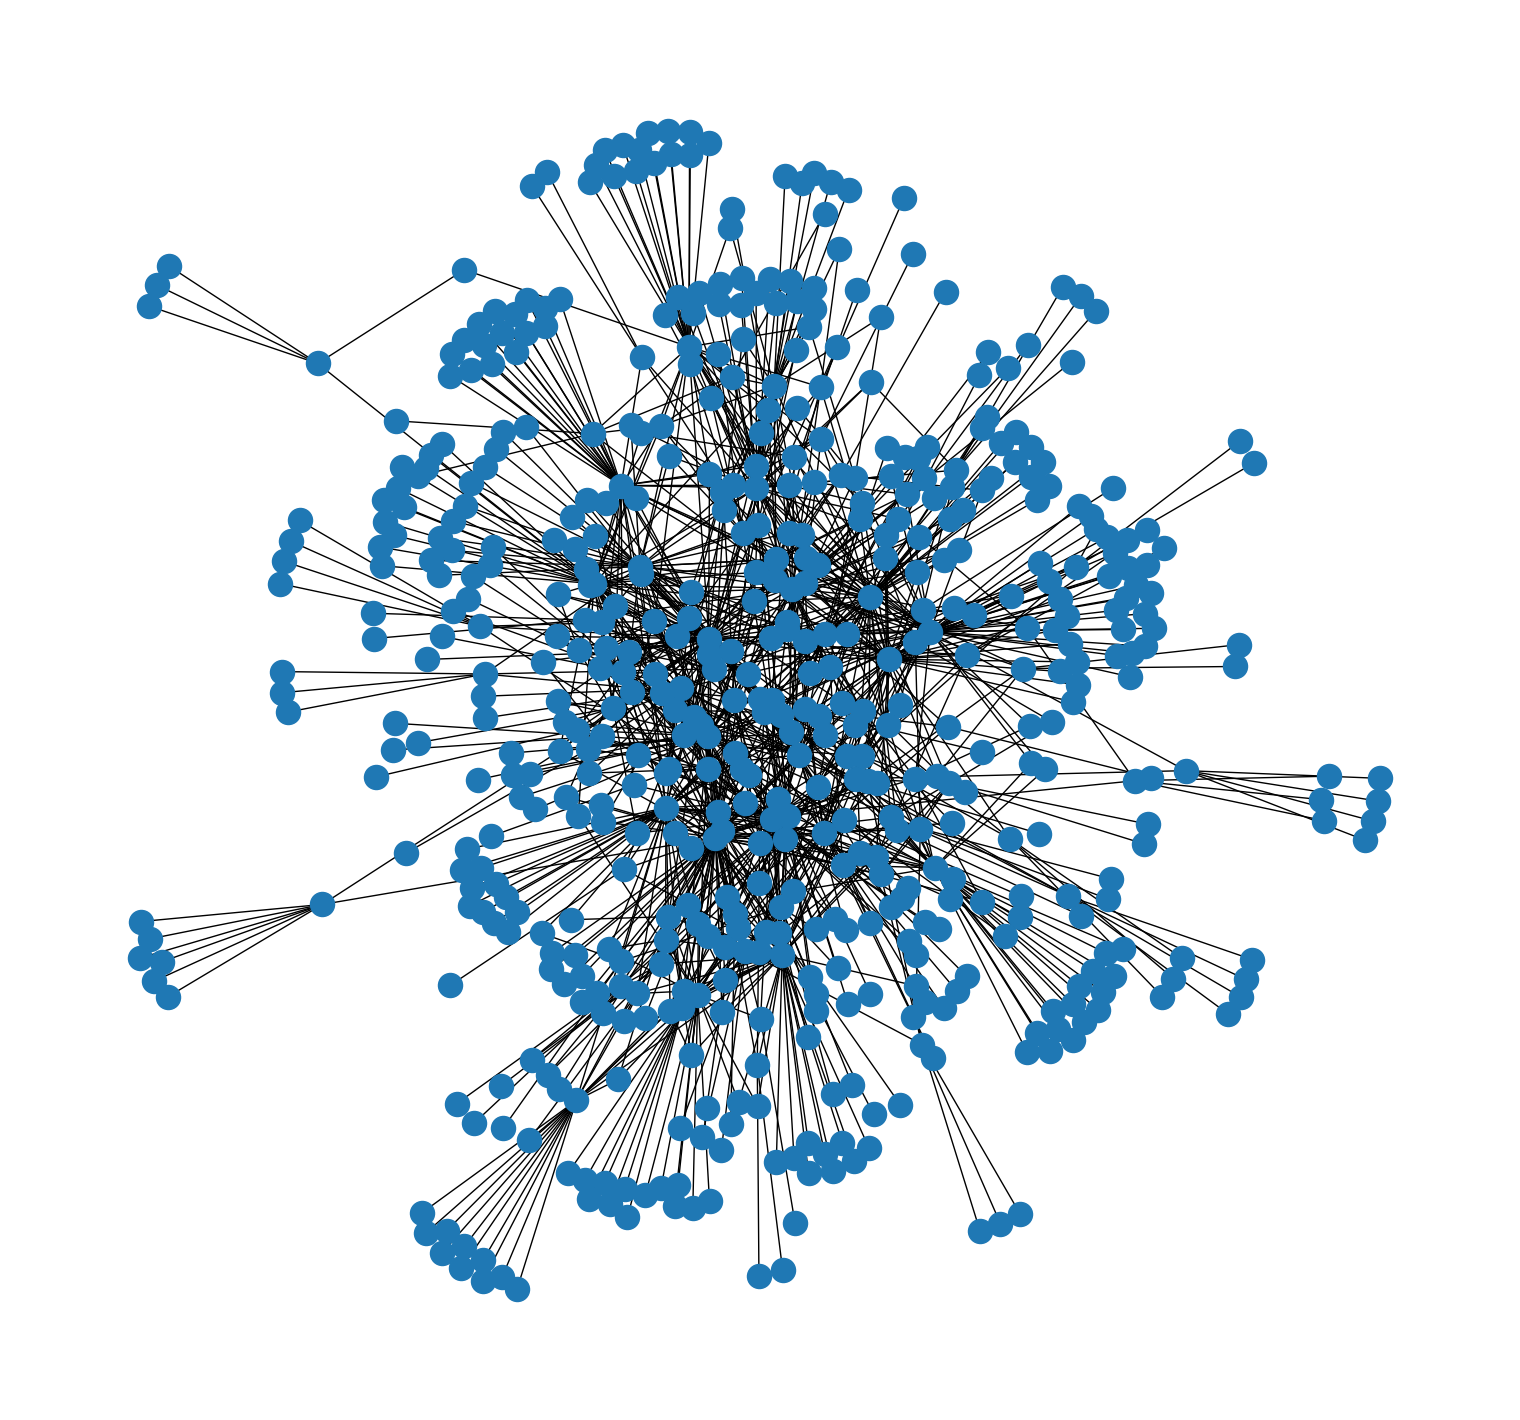

In [9]:
# 可视化
plt.figure(figsize=(15,14))
nx.draw(G)
plt.show()

## 生成随机游走节点序列的函数

In [10]:
def get_randomwalk(node, path_length):
    '''
    输入起始节点和路径长度，生成随机游走节点序列
    '''
    
    random_walk = [node]
    
    for i in range(path_length-1):
        # 汇总邻接节点
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        # 从邻接节点中随机选择下一个节点
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [11]:
all_nodes = list(G.nodes())

In [12]:
all_nodes

['科技猎手',
 '科技猎手2023',
 '航空',
 'DIY',
 '搞笑',
 '科技',
 '极客DIY',
 '黑科技',
 '手机',
 '软件应用',
 '数码',
 '知识',
 '科学科普',
 '智轨电车',
 '万物研究所·第十期',
 '中国制造',
 '必剪创作',
 '计算机技术',
 'opporeno10',
 '科普',
 '人工智能',
 '科学',
 'SOTA',
 '科工机械',
 '特种兵式旅游',
 '工程机械',
 '转场',
 '万物研究所',
 '人类史',
 '科学史',
 'FOXP2',
 '魅族18',
 'C++',
 'C/C++',
 'c++教程',
 'bilibili旅行奇遇记',
 '飞机',
 '旅游',
 '生活',
 '出行',
 '情侣',
 '生活记录',
 '知识分享官',
 '校园学习',
 '国泰航空',
 '心理学',
 '人文',
 '社科·法律·心理',
 '男生',
 '是老师，也是UP主！',
 '英语',
 '要素过多',
 '哲学',
 '教育',
 '学习',
 '小姐姐',
 '模仿',
 '航空公司',
 '空姐',
 '春日迷影电影院',
 '美国电影',
 '电影解说',
 '影视',
 '影视杂谈',
 '电影',
 '空中浩劫',
 '历史',
 '国家地理',
 '空难',
 '空难调查',
 '纪录片',
 '日常',
 '舱内音乐',
 '机械',
 '混剪',
 '暑期爆肝挑战',
 '傲慢',
 '一起做手工吧！',
 '手工',
 '制作',
 '创意',
 '技术宅',
 '电路',
 '寻找2233位手工大神',
 '旧光驱改造',
 '原创',
 '手工制作',
 '做一种很新的手工',
 '美妆',
 '硬核',
 '自制',
 '手工绘画达人秀',
 '滴胶',
 '制作教程',
 '装机',
 '显卡',
 '搞笑研究所',
 '是在下输了',
 '万恶之源',
 '高能',
 '配音',
 '奇葩',
 '娱乐',
 '段子',
 '名场面',
 '娱乐杂谈',
 '爆笑',
 '谭谈交通',
 '同人配音',
 '影视剪辑',
 '剪辑',
 '高启盛',
 '高启强',
 'PR教程',
 '野生技能协会',
 '视

In [15]:
get_randomwalk('手机', 5)

['手机', '科技猎手', 'DIY', '制作', '一起做手工吧！']

## 生成随机游走序列

In [16]:
gamma = 10 # 每个节点作为起始点生成随机游走序列个数
walk_length = 5 # 随机游走序列最大长度

In [17]:
random_walks = []

for n in tqdm(all_nodes): # 遍历每个节点
    for i in range(gamma): # 每个节点作为起始点生成gamma个随机游走序列
        random_walks.append(get_randomwalk(n, walk_length))

100%|██████████████████████████████████████████████████████████████████████████████| 576/576 [00:00<00:00, 2647.88it/s]


In [18]:
# 生成随机游走序列个数
len(random_walks)

5760

In [19]:
random_walks[1]

['科技猎手', '数码', '一年一度好物大赛', '打卡挑战']

## 训练Word2Vec模型

In [20]:
from gensim.models import Word2Vec # 自然语言处理

In [21]:
model = Word2Vec(vector_size=32, # Embedding维数
                 window=1, # 窗口宽度
                 sg=1, # Skip-Gram
                 hs=0, # 不加分层softmax
                 negative=10, # 负采样
                 alpha=0.03,  # 初始学习率
                 min_alpha=0.0007, # 最小学习率
                 seed=14 # 随机数种子
                )

In [22]:
# 用随机游走序列构建词汇表
model.build_vocab(random_walks, progress_per=2)

In [23]:
# 训练（耗时1分钟左右）
model.train(random_walks, total_examples=model.corpus_count, epochs=50, report_delay=1)

(946370, 1260900)

## 分析Word2Vec结果

In [27]:
# 查看某个节点的Embedding
model.wv.get_vector('手机').shape

(32,)

In [28]:
model.wv.get_vector('手机')

array([ 0.08140499, -1.011119  , -1.0494034 ,  0.19019087,  0.680805  ,
        1.4560049 , -0.8114287 , -0.8094264 ,  0.1705997 ,  0.26054093,
        0.04624677,  0.97318554,  0.6422785 ,  0.12102784,  0.26275828,
        0.73933035,  1.1438191 ,  1.4181001 ,  0.80315095, -0.9542759 ,
       -0.21092568, -1.022266  , -0.4826785 ,  0.8668294 , -1.4302158 ,
        0.26768336,  0.9721833 ,  0.6084431 , -0.11434447, -0.30686355,
       -0.91208744,  0.20174731], dtype=float32)

In [29]:
# 找相似词语
model.wv.similar_by_word('手机')

[('OriginOS', 0.8030864000320435),
 ('手机推荐', 0.7841867208480835),
 ('618', 0.7666535973548889),
 ('小米手机', 0.7642863392829895),
 ('我和数码的日常', 0.7540899515151978),
 ('小米', 0.749549925327301),
 ('苹果', 0.6836255192756653),
 ('推荐', 0.6804629564285278),
 ('手机评测', 0.6558598875999451),
 ('安卓', 0.6392790675163269)]

## PCA降维可视化

### 可视化全部词条的二维Embedding

In [30]:
X = model.wv.vectors

In [31]:
# 将Embedding用PCA降维到2维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

In [32]:
embed_2d.shape

(576, 2)

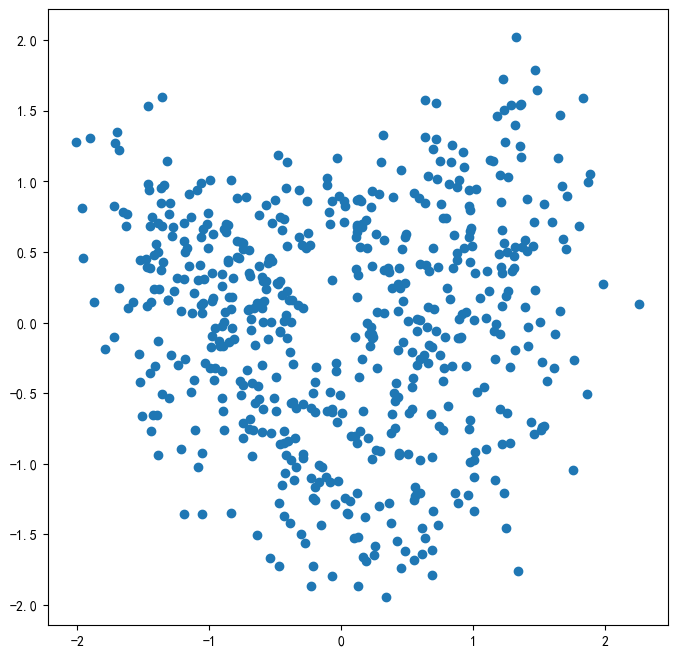

In [34]:
plt.figure(figsize=(8,8))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

### 可视化某个词条的二维Embedding

In [35]:
term = '手机'

In [36]:
term_256d = model.wv[term].reshape(1,-1)

In [37]:
term_256d.shape

(1, 32)

In [38]:
term_2d = pca.transform(term_256d)

In [39]:
term_2d

array([[1.6874565 , 0.59179425]], dtype=float32)

In [75]:
# 查找 嘻哈 节点的相似节点
model.wv.most_similar('DIY')

[('旧光驱改造', 0.7798157334327698),
 ('滴胶', 0.7572960257530212),
 ('制作教程', 0.7352961897850037),
 ('硬核', 0.7258694767951965),
 ('制作', 0.7247263193130493),
 ('创意', 0.7242995500564575),
 ('美妆', 0.6991652846336365),
 ('手工绘画达人秀', 0.6601964235305786),
 ('电路', 0.6528704762458801),
 ('手工', 0.6525855660438538)]

In [74]:
# 查看任意两个节点的相似度
model.wv.similarity('玩具', '推荐')

0.7422688

In [70]:
# 查看任意两个节点的相似度
model.wv.similarity('DIY', '旅游')

0.20495027

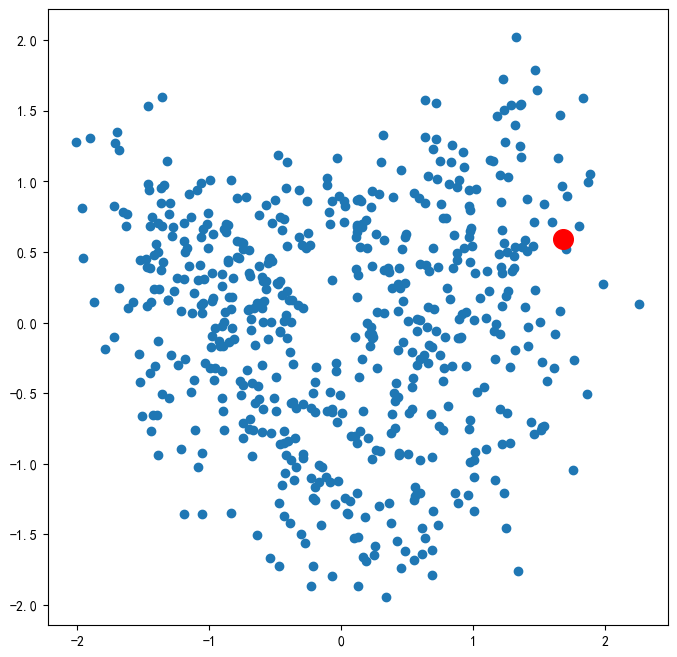

In [48]:
plt.figure(figsize=(8,8))
plt.scatter(embed_2d[:,0], embed_2d[:,1])
plt.scatter(term_2d[:,0],term_2d[:,1],c='r',s=200)
plt.show()

### 可视化某些词条的二维Embedding

In [49]:
# 计算PageRank重要度
pagerank = nx.pagerank(G)
# 从高到低排序
node_importance = sorted(pagerank.items(), key=lambda x:x[1], reverse=True)

In [50]:
# 取最高的前n个节点
n = 50
terms_chosen = []
for each in node_importance[:n]:
    terms_chosen.append(each[0])

In [51]:
# 手动补充新节点
# terms_chosen.extend(['computer vision','deep learning','convolutional neural network','convolution','natural-language processing','attention (machine learning)','support-vector machine','decision tree','random forest','computational imaging','machine vision','cognitive science','neuroscience','psychophysics','brain','visual cortex','visual neuroscience','cognitive model','finite difference','finite difference time domain','finite difference coefficients','finite difference methods for option pricing','iso 128','iso 10303'])


In [52]:
terms_chosen

['科技',
 '知识',
 '中国制造',
 '科技猎手2023',
 '搞笑',
 '必剪创作',
 '数码',
 '科普',
 '生活',
 '转场',
 '智轨电车',
 '旅游',
 '航空',
 '特种兵式旅游',
 '工程机械',
 '黑科技',
 '计算机技术',
 '手机',
 '科学科普',
 '飞机',
 'bilibili旅行奇遇记',
 '万物研究所·第十期',
 'opporeno10',
 'DIY',
 '科工机械',
 '极客DIY',
 '软件应用',
 '电脑配置',
 '动画',
 'CPU',
 '日常',
 '科学',
 '科技猎手',
 '机械',
 '纪实',
 '影视',
 '搞笑研究所',
 '魅族18',
 '校园学习',
 '野生技术协会',
 '历史',
 '这就是中国制造',
 '人工智能',
 '影视剪辑',
 '动画短片群星计划',
 '知识分享官',
 '短片',
 '动画短片',
 '手工',
 '星计划']

In [53]:
# 输入词条，输出词典中的索引号
term2index = model.wv.key_to_index

In [54]:
# index2term = model.wv.index_to_key
# term_index = np.array(term2index.values())

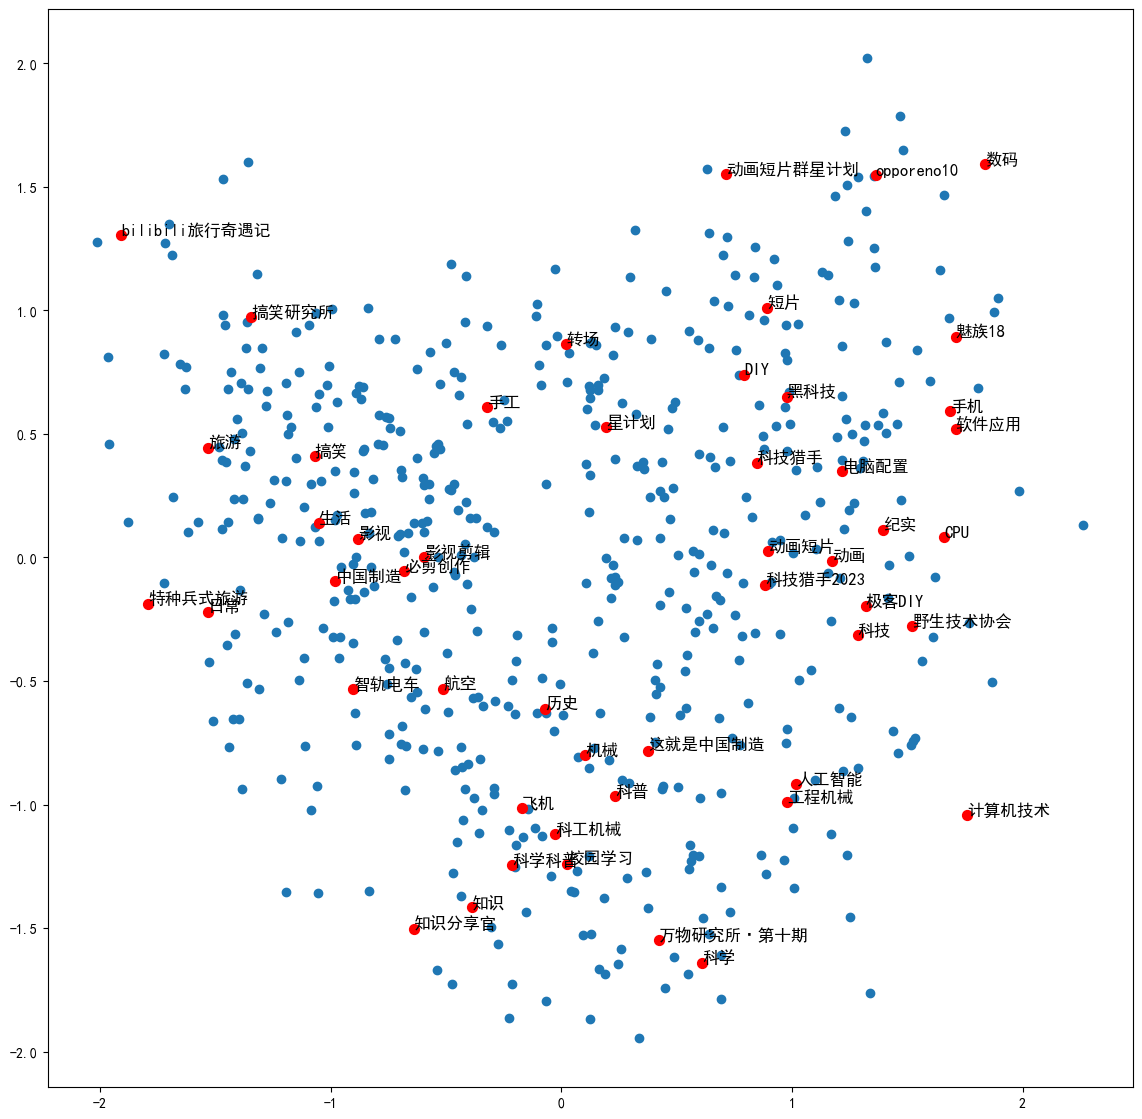

In [55]:
# 可视化全部词条和关键词条的二维Embedding
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:,0], embed_2d[:,1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx,0], embed_2d[idx,1],c='r',s=50)
    plt.annotate(item, xy=(embed_2d[idx,0], embed_2d[idx,1]),c='k',fontsize=12)
plt.show()

## TSNE降维可视化

### 可视化全部词条的二维Embedding¶

In [56]:
# 将Embedding用TSNE降维到2维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
embed_2d = tsne.fit_transform(X)

D:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


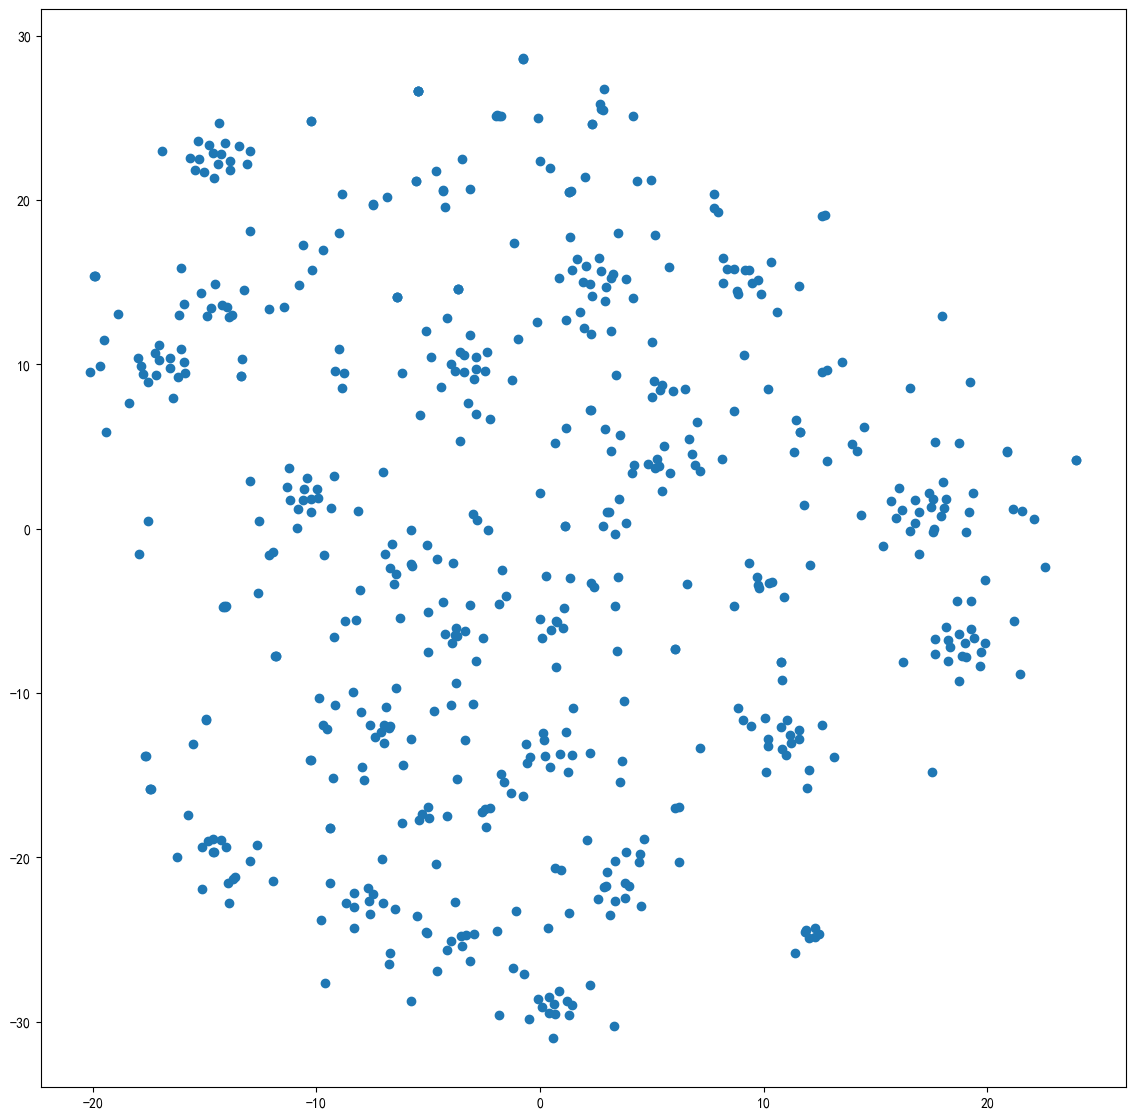

In [57]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

### 可视化全部词条和关键词条的二维Embedding

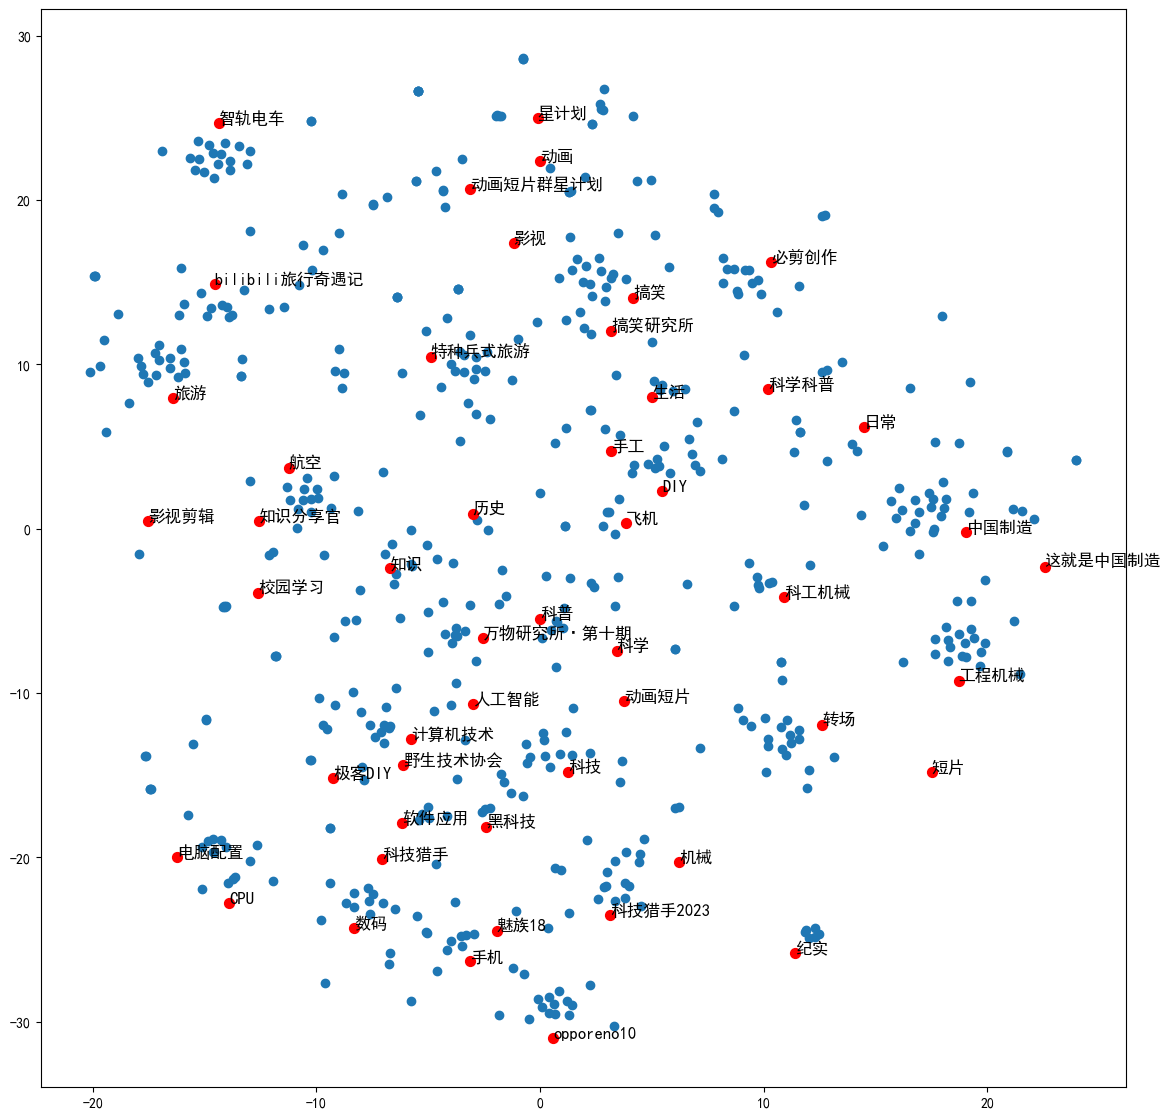

In [64]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:,0], embed_2d[:,1])

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx,0], embed_2d[idx,1],c='r',s=50)
    plt.annotate(item, xy=(embed_2d[idx,0], embed_2d[idx,1]),c='k',fontsize=12)
plt.show()

In [59]:
embed_2d.shape

(576, 2)

### 导出TSNE降维到二维之后的Embedding

In [60]:
terms_chosen_mask = np.zeros(X.shape[0])
for item in terms_chosen:
    idx = term2index[item]
    terms_chosen_mask[idx] = 1

In [61]:
df = pd.DataFrame()
df['X'] = embed_2d[:,0]
df['Y'] = embed_2d[:,1]
df['item'] = model.wv.index_to_key
df['pagerank'] = pagerank.values()
df['chosen'] = terms_chosen_mask

In [62]:
df

,X,Y,item,pagerank,chosen
0,1.252573,-14.776278,科技,0.004904,1.0
1,-6.705619,-2.412387,知识,0.017677,1.0
2,19.050228,-0.223657,中国制造,0.013833,1.0
3,3.119399,-23.505655,科技猎手2023,0.008744,1.0
4,4.164757,14.057282,搞笑,0.017225,1.0
...,...,...,...,...,...
571,17.562740,1.818265,川建国,0.000631,0.0
572,10.212168,-12.817887,主机游戏,0.000631,0.0
573,5.206938,4.234141,制作教程,0.000608,0.0
574,-14.418065,22.158140,轨道交通,0.000608,0.0


In [63]:
df.to_csv('./res/tsne_vis_2d.csv',index=False)